<a href="https://colab.research.google.com/github/Sergey-Kiselev-dev/ML_sem_pub/blob/main/ML_04_selfedu_ml_44a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#43. Алгоритм AdaBoost в задачах регрессии | Машинное обучение
# https://www.youtube.com/watch?v=uu5CHf0yi_c&list=PLA0M1Bcd0w8zxDIDOTQHsX68MCDOAJDtj&index=44
# https://github.com/selfedu-rus/machine_learning/blob/main/machine_learning_43_adaboost_regression.py

# Алгоритм регрессии AdaBoost на решающих деревьях

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

np.random.seed(123)

x = np.arange(0, np.pi/2, 0.1).reshape(-1, 1)
y = np.sin(x) + np.random.normal(0, 0.1, x.shape)

# plt.plot(x, y)
# plt.grid()
# plt.show()

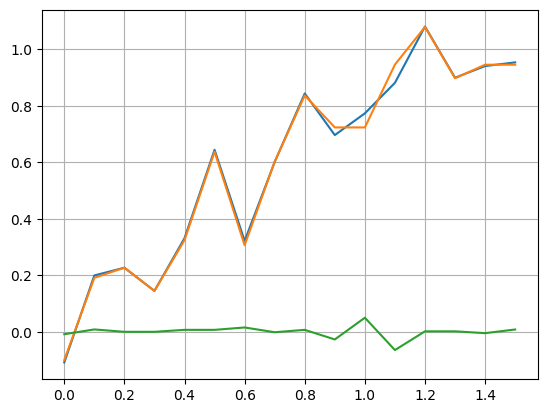

In [ ]:
T = 6                   # число алгоритмов в композиции
max_depth = 2           # максимальная глубина решающих деревьев
algs = []               # список из полученных алгоритмов
s = np.array(y.ravel())
for n in range(T):
    # создаем и обучаем решающее дерево
    algs.append(DecisionTreeRegressor(max_depth=max_depth))
    algs[-1].fit(x, s)

    s -= algs[-1].predict(x)    # пересчитываем остатки


# восстанавливаем исходный сигнал по набору полученных деревьев
yy = algs[0].predict(x)
for n in range(1, T):
    yy += algs[n].predict(x)

# отображаем результаты в виде графиков
plt.plot(x, y)      # исходный график
plt.plot(x, yy)     # восстановленный график
plt.plot(x, s)      # остаточный сигнал
plt.grid()
plt.show()